In [1]:
! pip install kaggle


In [3]:
!ls
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!ls

kaggle.json  sample_data
kaggle.json  sample_data


In [5]:
! kaggle datasets download soujanyasatpute/celeb-facial-recognition


 99% 231M/233M [00:01<00:00, 138MB/s]
100% 233M/233M [00:01<00:00, 124MB/s]


In [12]:
!pip install keras.applications

     |████████████████████████████████| 50 kB 2.7 MB/s 


In [15]:
from keras.applications.vgg16 import VGG16
rows = 224
cols = 224
model = VGG16(weights = 'imagenet', include_top = False, input_shape = (rows, cols, 3))

for layer in model.layers:
    layer.trainable = False

for (i,layer) in enumerate(model.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

58900480/58889256 [==============================] - 0s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [16]:
def addlayer(bottom_model, num_classes):
    """creates the head of the model that will bw placed on top of the bottom layers"""
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [17]:
model.input


<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [18]:
model.layers


In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import BatchNormalization
from keras.models import Model

num_classes = 2

FC_Head = addlayer(model, num_classes)
modelnew = Model(inputs=model.input, outputs=FC_Head)
print(modelnew.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
! kaggle datasets download soujanyasatpute/personalfacer


  0% 0.00/5.75M [00:00<?, ?B/s]
100% 5.75M/5.75M [00:00<00:00, 118MB/s]


In [22]:
!unzip /content/personalfacer.zip

Archive:  /content/personalfacer.zip
  inflating: Database/Test/Kaustubh/Kaustubh15.jpeg  
  inflating: Database/Test/Kaustubh/Kaustubh16.jpeg  
  inflating: Database/Test/Kaustubh/Kaustubh17.jpeg  
  inflating: Database/Test/Soujanya/SOujanya13.jpg  
  inflating: Database/Test/Soujanya/SOujanya14.jpg  
  inflating: Database/Test/Soujanya/Soujanya3.jpg  
  inflating: Database/Train/Kaustubh/Kaustubh1.jpeg  
  inflating: Database/Train/Kaustubh/Kaustubh10.jpeg  
  inflating: Database/Train/Kaustubh/Kaustubh11.jpeg  
  inflating: Database/Train/Kaustubh/Kaustubh12.jpeg  
  inflating: Database/Train/Kaustubh/Kaustubh13.jpeg  
  inflating: Database/Train/Kaustubh/Kaustubh14.jpeg  
  inflating: Database/Train/Kaustubh/Kaustubh15.jpeg  
  inflating: Database/Train/Kaustubh/Kaustubh16.jpeg  
  inflating: Database/Train/Kaustubh/Kaustubh2.jpeg  
  inflating: Database/Train/Kaustubh/Kaustubh3.jpeg  
  inflating: Database/Train/Kaustubh/Kaustubh4.jpeg  
  inflating: Database/Train/Kaustubh/Kaust

In [23]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = ('/content/Database/Train')
validation_data_dir = ('/content/Database/Test')


train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 15
val_batchsize = 10

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(rows, cols),
                                                    batch_size=train_batchsize,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                    target_size=(rows, cols),
                                                    batch_size=val_batchsize,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 32 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [50]:
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("face_recog_vgg.h5", monitor="val_loss", mode="min", save_best_only = True, verbose=1)
earlystop = EarlyStopping(monitor= 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True)
callbacks = [earlystop, checkpoint]

modelnew.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001),metrics=['accuracy'])

nb_train_samples=1190
nb_validation_samples=170
epochs=4
batch_size=16

history = modelnew.fit_generator(train_generator,
                                #  steps_per_epoch=nb_train_samples // batch_size,
                                 epochs=epochs,
                                 callbacks=callbacks,
                                 validation_data=validation_generator,
                                #  validation_steps=nb_validation_samples // batch_size
                                 )
# history = model.fit()
modelnew.save("face_recog_vgg.h5")
# model_json = modelnew.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("face_recog_vgg.h5")
# print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/4
3/3 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1: val_loss improved from inf to 0.00000, saving model to face_recog_vgg.h5
3/3 [==============================] - 22s 6s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/4
3/3 [==============================] - ETA: 0s - loss: 1.4901e-08 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 0.00000
3/3 [==============================] - 20s 6s/step - loss: 1.4901e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/4
3/3 [==============================] - ETA: 0s - loss: 2.2352e-08 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.00000
3/3 [==============================] - 20s 6s/step - loss: 2.2352e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/4
3/3 [==============================] - ETA: 0s - loss: 0.9931 - accuracy: 0.9688Restoring model weights from the end of the 

In [51]:
from keras.models import load_model
classifier = load_model('face_recog_vgg.h5')

Class - Kaustubh


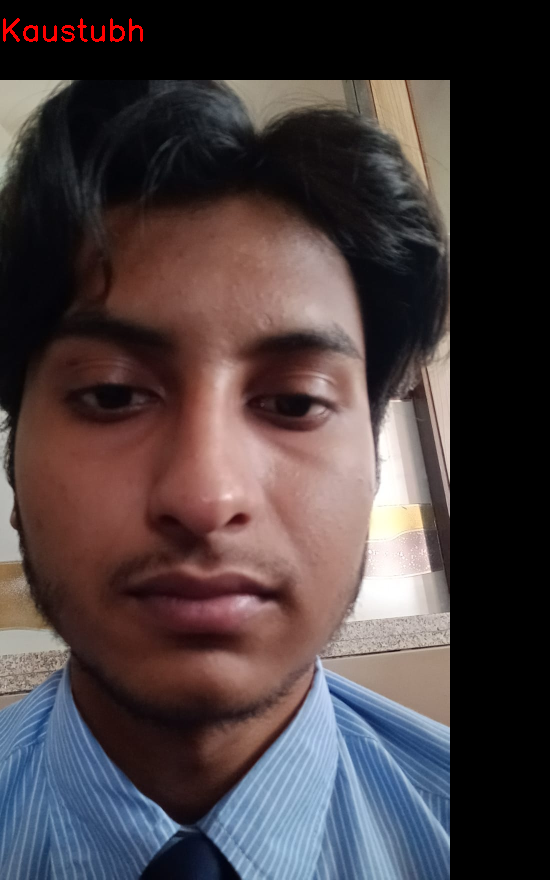

In [45]:
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow
actors_dataset_dict = {"[0]": "Kaustubh", 
                      "[1]": "Soujanya",
                      
                      }
def draw_test(name, pred, im):
    actors = actors_dataset_dict[str(pred)]
    BLACK = [0,0,0]
    # im = cv2.resize(img,(240,240)) 
    # im = img.reshape(1,240,240,3) 
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, actors, (0, 40) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2_imshow(expanded_image)
def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + str(path_class))
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)   
input_im = getRandomImage("/content/Database/Test/")
input_original = input_im.copy()
input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
input_im = cv2.resize(input_im, (240,240), interpolation = cv2.INTER_LINEAR)
input_im = input_im / 255.
input_im = input_im.reshape(1,240,240,3) 
res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
draw_test("Prediction", res, input_original) 
cv2.waitKey(5000)
cv2.destroyAllWindows()
